#
###Herman Olvik & Cornelia Swartling

##Data Initialization
To work with the small dataset, run only "Initialize the small dataset" below. If you want to work with the large dataset, run "Initialize the large dataset + consensus analysis" instead. All of the code is implemented to run properly with the dataset of your choice. Under "Other Models Evaluated", instructions relevant to the code below that section is presented.

###Initialize the small dataset

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string

# Loading the data
file_path = 'a3_train_final.tsv'
data = pd.read_csv(file_path, sep='\t', header=None)

# Function to remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Convert to lowercase and remove punctuation
data[1] = data[1].str.lower().apply(remove_punctuation)

# Separate the dataset into features (X) and target (y)
X = data[1]
y = data[0]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###Initialize the large dataset + consensus analysis

Average Consensus Score for Training Dataset: 0.9965764239375873
Average Consensus Score for Testing Dataset: 1.0


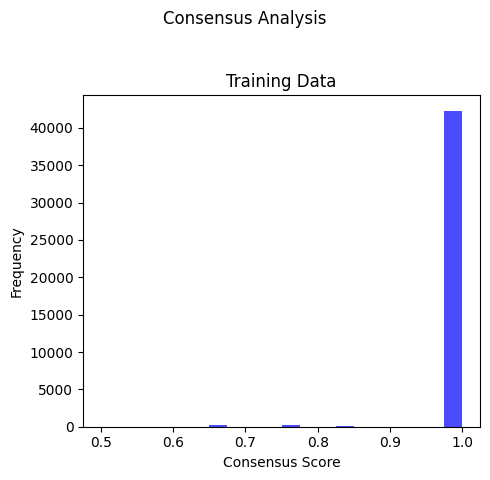

In [4]:
import pandas as pd
import string

def remove_punctuation(text):
    """Remove punctuation from a given string."""
    return text.translate(str.maketrans('', '', string.punctuation))

def preprocess_votes(row):
    """Preprocess votes to classify comments based on voting."""
    # Ensure the row is treated as a string
    row_str = str(row)
    votes = list(map(int, row_str.split('/')))
    pro_votes = votes.count(1)
    anti_votes = votes.count(0)
    neither_votes = votes.count(-1)

    if pro_votes == anti_votes or (pro_votes == neither_votes and pro_votes != 0) or (anti_votes == neither_votes and anti_votes != 0):
        return None  # Dismiss comments with tied votes or no clear majority

    if pro_votes > max(anti_votes, neither_votes):
        return 'pro'
    elif anti_votes > max(pro_votes, neither_votes):
        return 'anti'
    else:
        return None  # Dismiss comments where no majority is clear

# Loading the training and testing data
train_file_path = 'a3_train_final.tsv'
test_file_path = 'a3_test.tsv'

train_data = pd.read_csv(train_file_path, sep='\t', header=None)
test_data = pd.read_csv(test_file_path, sep='\t', header=None)

# Preprocess labels
train_data['processed_label'] = train_data[0].apply(preprocess_votes)
test_data['processed_label'] = test_data[0].apply(preprocess_votes)

# Convert to lowercase and remove punctuation from text data
train_data[1] = train_data[1].str.lower().apply(remove_punctuation)
test_data[1] = test_data[1].str.lower().apply(remove_punctuation)

# Remove dismissed comments
train_data.dropna(subset=['processed_label'], inplace=True)
test_data.dropna(subset=['processed_label'], inplace=True)

# Separate the dataset into features (X) and target (y) for both training and testing sets
X_train = train_data[1]
y_train = train_data['processed_label']
X_test = test_data[1]
y_test = test_data['processed_label']


''' Consensus analysis '''

def calculate_consensus_proportion(row):
    row_str = str(row)
    votes = list(map(int, row_str.split('/')))
    if not votes:
        return 0  # Handle empty votes

    pro_votes = votes.count(1)
    anti_votes = votes.count(0)
    neither_votes = votes.count(-1)
    total_votes = len(votes)

    majority_votes = max(pro_votes, anti_votes, neither_votes)
    if total_votes == 0:  # Prevent division by zero
        return 0
    consensus_proportion = majority_votes / total_votes
    return consensus_proportion

# Apply the function to each row and calculate the average consensus score
train_consensus_scores = train_data[0].apply(calculate_consensus_proportion)
test_consensus_scores = test_data[0].apply(calculate_consensus_proportion)

average_consensus_train = train_consensus_scores.mean()
average_consensus_test = test_consensus_scores.mean()

print("Average Consensus Score for Training Dataset:", average_consensus_train)
print("Average Consensus Score for Testing Dataset:", average_consensus_test)

import matplotlib.pyplot as plt

# Assuming calculate_consensus_proportion is already defined as before

# Apply the function to each row to calculate consensus scores
train_consensus_scores = train_data[0].apply(calculate_consensus_proportion)
test_consensus_scores = test_data[0].apply(calculate_consensus_proportion)

# Plotting
fig, ax = plt.subplots(figsize=(5, 5))

# Training dataset consensus distribution
ax.hist(train_consensus_scores.dropna(), bins=20, color='blue', alpha=0.7)
ax.set_title('Training Data')
ax.set_xlabel('Consensus Score')
ax.set_ylabel('Frequency')

plt.suptitle('Consensus Analysis')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##Logistic Regression - Tuning and Evaluation

###TfidfVectorizer + LogisticRegression, Including Feature Importances and Confusion Matrix



0.8921039725355566
              precision    recall  f1-score   support

        anti       0.89      0.90      0.89      1020
         pro       0.90      0.89      0.89      1019

    accuracy                           0.89      2039
   macro avg       0.89      0.89      0.89      2039
weighted avg       0.89      0.89      0.89      2039

antivaxxers: 16.90530573911103
never: -11.762921529919959
poison: -10.859831762711918
no side: 9.853772167838509
get: 9.426815779407631
forced: -8.874936291628096
antivaxers: 8.752909708928474
experimental: -8.511786691590801
antivaxx: 8.429187523435006
anti vaxxers: 8.089538901887877


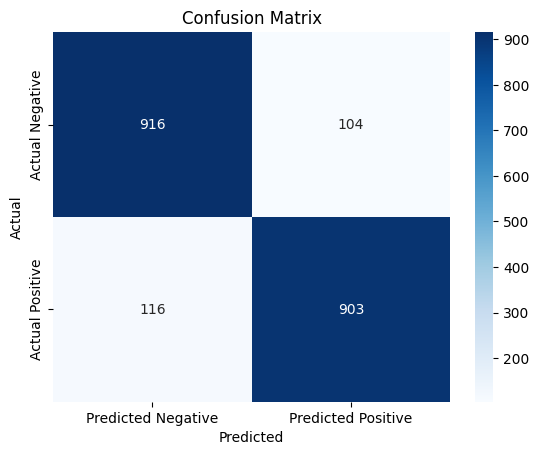

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# These are the optimal parameters based on GridSearchCV
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2),
                              max_df=0.75,
                              max_features=None,
                              min_df=2)),
    ('classifier', LogisticRegression(C=10, solver='liblinear', random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(accuracy)
print(report)


''' Feature analysis '''

# Access the classifier and vectorizer from the pipeline
classifier = pipeline.named_steps['classifier']
vectorizer = pipeline.named_steps['tfidf']

# Get the feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get the coefficients from the classifier
coefficients = classifier.coef_[0]

# Pair up feature names with their coefficients
feature_importance = zip(feature_names, coefficients)

# Sort features by their absolute values of coefficients, in descending order
important_features = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)

# Print the top N most important features
for feature, coef in important_features[:10]:
    print(f"{feature}: {coef}")


''' Confusion matrix '''

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix with heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Negative", "Predicted Positive"], yticklabels=["Actual Negative", "Actual Positive"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


###TfidfVectorizer + LogisticRegression Parameter Tuning

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('classifier', LogisticRegression(random_state=42))
])

# Parameters grid for GridSearchCV
param_grid = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [1, 2, 3],
    'tfidf__max_features': [None, 5000, 10000],
    'classifier__C': [0.01, 0.1, 1, 10, 100, 200, 500],
    'classifier__solver': ['liblinear', 'saga']
}

# Grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Output the best set of parameters
print("Best Parameters Set Found On Development Set:")
print(grid_search.best_params_)

# Best model after grid search
best_model = grid_search.best_estimator_

# Predict on the test set with the best model
y_pred = best_model.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Best Model Accuracy: ", accuracy)
print("Classification Report: \n", report)

Fitting 5 folds for each of 378 candidates, totalling 1890 fits
Best Parameters Set Found On Development Set:
{'classifier__C': 10, 'classifier__solver': 'saga', 'tfidf__max_df': 0.75, 'tfidf__max_features': None, 'tfidf__min_df': 1}
Best Model Accuracy:  0.8921039725355566
Classification Report: 
               precision    recall  f1-score   support

        anti       0.89      0.89      0.89      1020
         pro       0.89      0.89      0.89      1019

    accuracy                           0.89      2039
   macro avg       0.89      0.89      0.89      2039
weighted avg       0.89      0.89      0.89      2039



##Support Vector Classifier - Tuning and Evaluation

###TfidfVectorizer + SVC, Including Confusion Matrix

0.8965179009318294
              precision    recall  f1-score   support

        anti       0.89      0.90      0.90      1020
         pro       0.90      0.89      0.90      1019

    accuracy                           0.90      2039
   macro avg       0.90      0.90      0.90      2039
weighted avg       0.90      0.90      0.90      2039



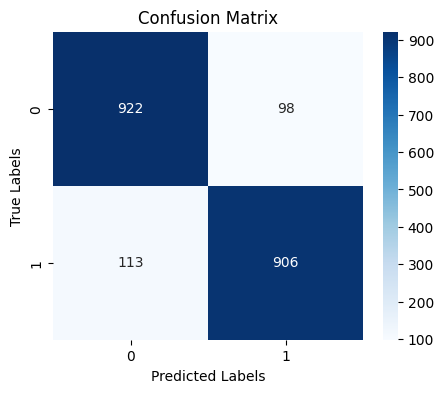

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Create a pipeline with TF-IDF Vectorizer and SVC classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2),
                              max_df=0.75,
                              max_features=None,
                              min_df=3)),
    ('classifier', SVC(C=10, gamma=1, kernel='rbf', random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(accuracy)
print(report)


''' Confusion matrix '''

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(5, 4))  # Set the figure size for better readability
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

###TfidfVectorizer + SVC Parameter Tuning

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV


pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('classifier', SVC(random_state=42))
])

# Parameters grid for GridSearchCV
param_grid = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [1, 2, 3],
    'tfidf__max_features': [None, 5000, 10000],
    'classifier__C': [0.01, 0.1, 1, 10, 100, 200, 500],
    'classifier__kernel': ['linear', 'rbf']
}

# Grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Output the best set of parameters
print("Best Parameters Set Found On Development Set:")
print(grid_search.best_params_)

# Best model after grid search
best_model = grid_search.best_estimator_

# Predict on the test set with the best model
y_pred = best_model.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Best Model Accuracy: ", accuracy)
print("Classification Report: \n", report)

##A Trivial Baseline Comparison

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import make_pipeline


# Create a pipeline with CountVectorizer and DummyClassifier
pipeline = make_pipeline(
    CountVectorizer(),  # Convert text data into numerical feature vectors
    DummyClassifier(strategy='most_frequent')  # Trivial baseline classifier
)

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Baseline Classifier Performance:")
print(classification_report(y_test, y_pred))

Baseline Classifier Performance:
              precision    recall  f1-score   support

           0       0.48      1.00      0.65        93
           1       0.00      0.00      0.00       102

    accuracy                           0.48       195
   macro avg       0.24      0.50      0.32       195
weighted avg       0.23      0.48      0.31       195



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Other Models Evaluated

###Data Initialization
Run this before running the cells below, to see which hyperparameters are the best for the various models. The small dataset is a better option when running the finding the optimal hyperparameters, since the large dataset is too time-consuming. Run this also before running the last cell, since those hyperparameters has already been set to the optimal ones.

In [28]:
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train = tfidf_vectorizer.fit_transform(X_train)

# Transform test data using the same vectorizer
X_test = tfidf_vectorizer.transform(X_test)

###Random Forest Classifier

In [29]:
from sklearn.ensemble import RandomForestClassifier

# Define lists of hyperparameters to try
n_estimators_values = [50, 100, 150]  # Number of trees in the forest
max_depth_values = [None, 10, 20]  # Maximum depth of the trees

# Initialize variables to store the best hyperparameters and best accuracy
best_hyperparameters = {}
best_accuracy = 0.0

# Iterate through different hyperparameter combinations
for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        # Initialize Random Forest classifier with current hyperparameters
        rf_classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)

        # Train the classifier on the training data
        rf_classifier.fit(X_train, y_train)

        # Predict on the testing data
        predictions = rf_classifier.predict(X_test)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, predictions)

        # Print hyperparameters and accuracy
        print("n_estimators:", n_estimators, "Max Depth:", max_depth, "Accuracy:", accuracy)

        # Check if current combination has better accuracy than the previous best
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_hyperparameters = {'n_estimators': n_estimators, 'max_depth': max_depth}

# Print the best hyperparameters and accuracy
print("Best Hyperparameters:", best_hyperparameters)
print("Best Accuracy:", best_accuracy)

n_estimators: 50 Max Depth: None Accuracy: 0.7435897435897436
n_estimators: 50 Max Depth: 10 Accuracy: 0.6923076923076923
n_estimators: 50 Max Depth: 20 Accuracy: 0.7128205128205128
n_estimators: 100 Max Depth: None Accuracy: 0.7435897435897436
n_estimators: 100 Max Depth: 10 Accuracy: 0.7230769230769231
n_estimators: 100 Max Depth: 20 Accuracy: 0.7384615384615385
n_estimators: 150 Max Depth: None Accuracy: 0.7435897435897436
n_estimators: 150 Max Depth: 10 Accuracy: 0.7076923076923077
n_estimators: 150 Max Depth: 20 Accuracy: 0.717948717948718
Best Hyperparameters: {'n_estimators': 50, 'max_depth': None}
Best Accuracy: 0.7435897435897436


###Gradient Boosting Classifier

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

# Define lists of hyperparameters to try
n_estimators_values = [50, 100, 150]  # Number of boosting stages
learning_rate_values = [0.01, 0.1, 0.5]  # Learning rate shrinks the contribution of each tree
max_depth_values = [3, 5, 7]  # Maximum depth of the individual trees

# Initialize variables to store the best hyperparameters and best accuracy
best_hyperparameters = {}
best_accuracy = 0.0

# Iterate through different hyperparameter combinations
for n_estimators in n_estimators_values:
    for learning_rate in learning_rate_values:
        for max_depth in max_depth_values:
            # Initialize Gradient Boosting classifier with current hyperparameters
            gb_classifier = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42)

            # Train the classifier on the training data
            gb_classifier.fit(X_train, y_train)

            # Predict on the testing data
            predictions = gb_classifier.predict(X_test)

            # Calculate accuracy
            accuracy = accuracy_score(y_test, predictions)

            # Print hyperparameters and accuracy
            print("n_estimators:", n_estimators, "learning_rate:", learning_rate, "Accuracy:", accuracy)

            # Check if current combination has better accuracy than the previous best
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_hyperparameters = {'n_estimators': n_estimators, 'learning_rate': learning_rate, 'max_depth': max_depth}

# Print the best hyperparameters and accuracy
print("Best Hyperparameters:", best_hyperparameters)
print("Best Accuracy:", best_accuracy)


n_estimators: 50 learning_rate: 0.01 Accuracy: 0.6051282051282051
n_estimators: 50 learning_rate: 0.01 Accuracy: 0.6410256410256411
n_estimators: 50 learning_rate: 0.01 Accuracy: 0.6358974358974359
n_estimators: 50 learning_rate: 0.1 Accuracy: 0.7076923076923077
n_estimators: 50 learning_rate: 0.1 Accuracy: 0.764102564102564
n_estimators: 50 learning_rate: 0.1 Accuracy: 0.7282051282051282
n_estimators: 50 learning_rate: 0.5 Accuracy: 0.7435897435897436
n_estimators: 50 learning_rate: 0.5 Accuracy: 0.6871794871794872
n_estimators: 50 learning_rate: 0.5 Accuracy: 0.7282051282051282
n_estimators: 100 learning_rate: 0.01 Accuracy: 0.6615384615384615
n_estimators: 100 learning_rate: 0.01 Accuracy: 0.6923076923076923
n_estimators: 100 learning_rate: 0.01 Accuracy: 0.7230769230769231
n_estimators: 100 learning_rate: 0.1 Accuracy: 0.7282051282051282
n_estimators: 100 learning_rate: 0.1 Accuracy: 0.7538461538461538
n_estimators: 100 learning_rate: 0.1 Accuracy: 0.7538461538461538
n_estimators: 

###Neural Network Classifier

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

# Define the feedforward neural network architecture
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Convert TF-IDF matrices to PyTorch tensors
train_inputs = torch.tensor(X_train.toarray(), dtype=torch.float32)
test_inputs = torch.tensor(X_test.toarray(), dtype=torch.float32)
train_labels = torch.tensor(y_train.values, dtype=torch.long)
test_labels = torch.tensor(y_test.values, dtype=torch.long)

# Define hyperparameters to try
hidden_size_values = [64, 128, 256]  # Sizes of hidden layers
learning_rate_values = [0.001, 0.01, 0.1]  # Learning rates

# Initialize variables to store the best hyperparameters and best accuracy
best_hyperparameters = {}
best_accuracy = 0.0

# Iterate through different hyperparameter combinations
for hidden_size in hidden_size_values:
    for learning_rate in learning_rate_values:
        # Instantiate the model, loss function, and optimizer with current hyperparameters
        model = FFNN(train_inputs.shape[1], hidden_size, 2)  # Use train_inputs.shape[1] for input size
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Define batch size and create DataLoader
        batch_size = 32
        train_dataset = TensorDataset(train_inputs, train_labels)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Training the model
        model.train()
        for epoch in range(3):  # Adjust number of epochs as needed
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            outputs = model(test_inputs)
            _, predicted = torch.max(outputs, 1)
            accuracy = accuracy_score(test_labels, predicted)

            # Print hyperparameters and accuracy
            print("Hidden Size:", hidden_size, "Learning Rate:", learning_rate, "Accuracy:", accuracy)

            # Check if current combination has better accuracy than the previous best
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_hyperparameters = {'hidden_size': hidden_size, 'learning_rate': learning_rate}

# Print the best hyperparameters and accuracy
print("Best Hyperparameters:", best_hyperparameters)
print("Best Accuracy:", best_accuracy)


Hidden Size: 64 Learning Rate: 0.001 Accuracy: 0.7589743589743589
Hidden Size: 64 Learning Rate: 0.01 Accuracy: 0.7435897435897436
Hidden Size: 64 Learning Rate: 0.1 Accuracy: 0.7692307692307693
Hidden Size: 128 Learning Rate: 0.001 Accuracy: 0.7538461538461538
Hidden Size: 128 Learning Rate: 0.01 Accuracy: 0.7282051282051282
Hidden Size: 128 Learning Rate: 0.1 Accuracy: 0.7230769230769231
Hidden Size: 256 Learning Rate: 0.001 Accuracy: 0.7435897435897436
Hidden Size: 256 Learning Rate: 0.01 Accuracy: 0.6974358974358974
Hidden Size: 256 Learning Rate: 0.1 Accuracy: 0.7282051282051282
Best Hyperparameters: {'hidden_size': 64, 'learning_rate': 0.1}
Best Accuracy: 0.7692307692307693


###Combining Multiple Classifiers
Run the code under "Data Initialization", "Other Models Evaluated" before running this code cell, to vectorize the data properly.

In [30]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC

# Initialize base classifiers
svc_classifier = SVC(C=10, gamma=1, kernel='rbf', probability=True)  # Set probability=True for SVC to enable soft voting
rf_classifier = RandomForestClassifier(n_estimators=50, max_depth=None, random_state=42)
gb_classifier = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=5)

# Define the voting classifier
voting_classifier = VotingClassifier(estimators=[('svc', svc_classifier), ('rf', rf_classifier), ('gb', gb_classifier)], voting='soft')

# Train the voting classifier
voting_classifier.fit(X_train, y_train)

# Evaluate the voting classifier
predictions = voting_classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Voting Classifier Accuracy:", accuracy)

# Define the stacking classifier
stacking_classifier = StackingClassifier(estimators=[('svc', svc_classifier), ('rf', rf_classifier), ('gb', gb_classifier)], final_estimator=LogisticRegression())

# Train the stacking classifier
stacking_classifier.fit(X_train, y_train)

# Evaluate the stacking classifier
predictions = stacking_classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Stacking Classifier Accuracy:", accuracy)


Voting Classifier Accuracy: 0.7692307692307693
Stacking Classifier Accuracy: 0.7487179487179487
